In [1]:
import os
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
path_1 = "./folder_05"
filename = "co_occ_pair.csv" #uncut
#"cutoff_pair.csv" cutted
print(filename)

co_occ_pair.csv


In [3]:
#カイ二乗検定で数を減らした症状疾患ペアデータを 変数名 co_occ_pair として読み込む
os.chdir(path_1)
co_occ_pair = pd.read_csv(filename)
co_occ_pair =co_occ_pair[['symptom', 'disease', 'co_occurrence']]

In [4]:
#symptomとペアになるdisease総数
idf_n_i = co_occ_pair.groupby("symptom").count().reset_index()[["symptom", "disease"]].values.tolist()
len(idf_n_i)

384

In [5]:
#TF-IDF
tfidf_list=[]
N = co_occ_pair["disease"].nunique()  #全疾患の種類数

for pair in tqdm(co_occ_pair.values.tolist()): #co_occ_pair：共起ペアと共起数
    for symptom in idf_n_i: #idf_n_i：symptomとdisease総数
        
        if pair[0]==symptom[0]: #同じsymptomだったら
            
            #Zhou数式
            W_ij = pair[-1] #diseaseとの共起数
            n_i = symptom[1] #symptomとペアになるdisease総数
            tfidf_value = W_ij*np.log(N /n_i) 
            
            tfidf_list.append([pair[0],  pair[1], W_ij, n_i, tfidf_value])

tfidf = pd.DataFrame(tfidf_list, columns=["symptom","disease","co_occurence", "disease_num", "tf_idf"])

#disease_num：symptomとペアになるdisease総数
tfidf = tfidf.sort_values(by="tf_idf", ascending=False).reset_index(drop=True)
print(tfidf["tf_idf"].sum())

  0%|          | 0/211838 [00:00<?, ?it/s]

8103060.840157608


In [6]:
#行列の形にする #cutted : 10308472.749203153
pivot_tfidf_df = tfidf.pivot(index='disease', columns='symptom', values='tf_idf').fillna(0)
print(pivot_tfidf_df.sum().sum())

8103060.840157606


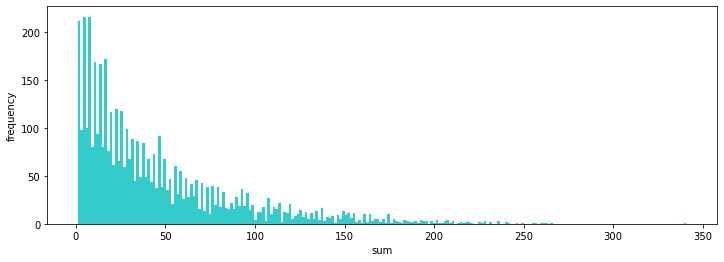

In [7]:
#疾患・症状のTFIDFがゼロより大きい値を取り出した時の可視化

plt.figure(figsize=(12,4))

#TFIDFの数
#plt.subplot(121)
each_disease_sum_vector = [sum(pivot_tfidf_df.loc[disease, :]>0) for disease in pivot_tfidf_df.index]
plt.hist(each_disease_sum_vector,color='c', bins=len(set(each_disease_sum_vector)), alpha=0.8)
plt.xlabel('sum')
plt.ylabel("frequency")
plt.show()

In [8]:
#コサイン類似度　計算

In [9]:
#コサイン算出用データフレームを作る
pre_cosine_df = tfidf.sort_values(['symptom', 'disease'])[['symptom', 'disease',"tf_idf"]].reset_index(drop=True)
pre_cosine_df = pd.pivot_table(pre_cosine_df, index='disease', columns='symptom', values="tf_idf")
pre_cosine_df = pre_cosine_df.fillna(0)#欠損値に0を入れる
#疾患個数
print(len(pre_cosine_df.index))

4716


In [10]:
#疾患ペア(直積ペア)を作る
import itertools
product_list = list(itertools.product(pre_cosine_df.index, pre_cosine_df.index))
print(len(product_list))
print(product_list[0], product_list[1])

22240656
('22q11 Deletion Syndrome', '22q11 Deletion Syndrome') ('22q11 Deletion Syndrome', '46, XX Disorders of Sex Development')


In [11]:
#tfidf行列を疾患（＝行）ごとに分けて直積ペアを作る
vectors = [each_vectors for each_vectors in np.array(pre_cosine_df)]
vectors_list = list(itertools.product(vectors, vectors))

In [12]:
#コサイン類似度

#計算式
def cosine_similarity(x, y):#xとyはベクトルの成分
    return (np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y))))

#直積ペアにコサイン類似度計算を適用 
cosine_similarity_list = []
for disease_pair, vector in tqdm(zip( product_list, vectors_list )):
    cosine_similarity_list.append([disease_pair[0], disease_pair[-1], cosine_similarity(vector[0], vector[1])])

0it [00:00, ?it/s]

In [13]:
#データフレーム化
cosine_df = pd.DataFrame(cosine_similarity_list, columns=["disease_1", "disease_2", "cosine_similarity"])
cosine_df = cosine_df.sort_values("cosine_similarity", ascending=False).reset_index(drop=True)
pivot_cosine_df = cosine_df.pivot(index='disease_1', columns='disease_2', values='cosine_similarity')#.fillna(0)
print(len(cosine_df), len(pivot_cosine_df))

22240656 4716


In [14]:
#インデックスを取得
pivot_index = pivot_cosine_df.index.tolist()

In [15]:
#「同じ疾患同士」「順序が逆になっているだけで同じペアの片方」を削除

#アレイに変換
recent_array = np.array(pivot_cosine_df)

#下三角行列を取得する
#numpy.tril()の引数にnumpy.ndarrayを指定すると、対角線より上の成分をゼロとしたnumpy.ndarrayが返される。
#対角線のコサイン値＝１は不要なので、この対角線箇所も含めてゼロにしたい。
#numpy.tril()の第二引数のkで、境界となる対角線の位置が指定できる（正の値だと上側（右側）、負の値だと下側（左側）に移動する）

recent_array = np.tril(recent_array, k=-1) 

#データフレームにする　対角線含む上の値がゼロになっているか確認
repivot_cosine_df= pd.DataFrame(recent_array, index=pivot_cosine_df.index, columns=pivot_cosine_df.columns)


In [16]:
#下三角行列から コサイン値ゼロ以外の値の位置を取得
recent_array_index_list = [[value_0,
                            value_1] for value_0, value_1 in zip(list(np.where(recent_array>0)[0]),
                                                                 list(np.where(recent_array>0)[1]))]
print(len(recent_array_index_list))
#cutted 7804331

9798961


In [17]:
#元の（半分ゼロにする前の）行列で同じ位置を指定し、そのインデックス（疾患ペア）と値（コサイン値）を取得
#疾患a, 疾患b, abのコサイン値
repivot_pair = [ [pivot_index[i[0]],
                  pivot_index[i[1]], 
                  repivot_cosine_df.iloc[i[0], i[1]]] for i in tqdm(recent_array_index_list)]

# 作成されるデータは
#    「同じ疾患同士」「順序が逆になっただけの同じペアのうちの片方」「コサイン値ゼロ」これらを除いたデータ

  0%|          | 0/9798961 [00:00<?, ?it/s]

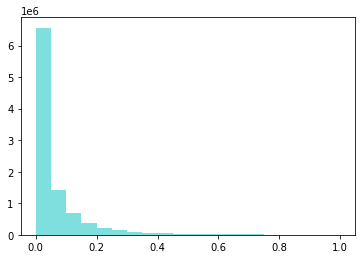

In [18]:
#コサイン値のヒストグラム
plt.hist( pd.DataFrame(repivot_pair)[2], alpha=0.5, bins=20, color='c') 
plt.show()

In [19]:
hsdn = pd.DataFrame(repivot_pair, columns=["disease_1", "disease_2", "cosine_similarity"])

In [20]:
print("疾患・症状の共起ペアの数:", len(tfidf))
print("disease_MeSHの種類数:", len(repivot_cosine_df.index))
print("symptom_MeSHの種類数:", len(idf_n_i), "\n")

疾患・症状の共起ペアの数: 211838
disease_MeSHの種類数: 4716
symptom_MeSHの種類数: 384 



In [21]:
print("ペアとなった疾患-疾患の数:", len(hsdn))
print("cos>0.1:", len(hsdn[hsdn["cosine_similarity"]>0.1]))
print("cos>0.2:", len(hsdn[hsdn["cosine_similarity"]>0.2]))
print("cos>0.5:", len(hsdn[hsdn["cosine_similarity"]>0.5]))

ペアとなった疾患-疾患の数: 9798961
cos>0.1: 1804465
cos>0.2: 749071
cos>0.5: 119872


In [22]:
print("cos>0.1を取り出したとき")
cos1 = hsdn[hsdn["cosine_similarity"]>0.1]
print("疾患-疾患ペアの数", len(cos1))
print("disease_MeSHの種類:", len(set(cos1["disease_1"].values.tolist() + cos1["disease_2"].values.tolist())))
print("cos_max:", cos1["cosine_similarity"].max())
print("cos_min:", cos1["cosine_similarity"].min(), "\n")

print("cos>0.1,cos<1を取り出したとき")
cos2 = hsdn[ (hsdn["cosine_similarity"]>0.1) & (hsdn["cosine_similarity"]<1)]
print("疾患-疾患ペアの数", len(cos2))
print("disease_MeSHの種類:", len(set(cos2["disease_1"].values.tolist() + cos2["disease_2"].values.tolist())))
print("cos_max:", cos2["cosine_similarity"].max())
print("cos_min:", cos2["cosine_similarity"].min())

cos>0.1を取り出したとき
疾患-疾患ペアの数 1804465
disease_MeSHの種類: 4715
cos_max: 1.0000000000000002
cos_min: 0.10000003281230621 

cos>0.1,cos<1を取り出したとき
疾患-疾患ペアの数 1804349
disease_MeSHの種類: 4715
cos_max: 0.9999912867681617
cos_min: 0.10000003281230621


In [23]:
# TF-IDFした後で、正のコサイン類似度を持つ疾患-疾患ペアの数は？
print(len(hsdn))

9798961


In [24]:
#networkにする
G = nx.from_pandas_edgelist( hsdn,"disease_1", "disease_2" )
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 4716
Number of edges: 9798961
Average degree: 4155.6238


ポイントの数は共起頻度数の種類数 1300


<ipython-input-25-53bf47feea02>:11: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.loglog(basex=10,basey=10)
<ipython-input-25-53bf47feea02>:11: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.loglog(basex=10,basey=10)


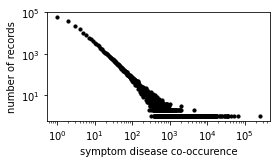

In [25]:
#一文献につき共起する数とその文献数

#両方の軸を対数スケールで設定する必要がある　loglog() 関数を使用
#loglog() 関数
#X 軸と Y 軸の両方に沿って対数スケーリングを行う時使える
#X 軸と Y 軸の対数の底は、basex パラメータと basey パラメータによって設定

a = pd.Series(co_occ_pair["co_occurrence"].value_counts())
plt.subplots(figsize=(4,2))
plt.scatter(a.index, a, color="black", s=10)
plt.loglog(basex=10,basey=10)
plt.xlabel("symptom disease co-occurence")
plt.ylabel("number of records",)
print("ポイントの数は共起頻度数の種類数", len(a))
plt.show()

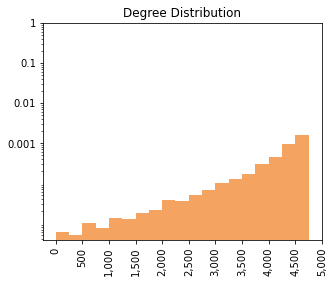

In [26]:
#次数のヒストグラムの形状
plt.subplots(figsize=(5,4))
bins = range(0,5000,250)
degrees_list = [val for (node, val) in G.degree()] #plt.yscale("log")
plt.hist(degrees_list, bins=bins,density=True,log=True, color="SandyBrown")
plt.xticks([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000],
           ["0", "500", "1,000", "1,500", "2,000", "2,500", "3,000", "3,500", "4,000", "4,500", "5,000"])
plt.xticks(rotation=90)
plt.yticks([1, 0.1, 0.01, 0.001],[1, 0.1, 0.01, 0.001])
plt.title('Degree Distribution')
plt.show()

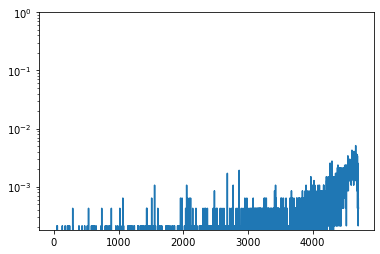

In [27]:
plt.yscale('log')
plt.plot([ degree/len(G.nodes) for degree in nx.degree_histogram(G)])
plt.yticks([0.001, 0.01, 0.1, 1])
plt.show()

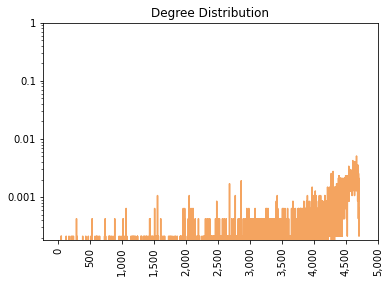

In [28]:
plt.yscale('log')
plt.plot([ degree/len(G.nodes) for degree in nx.degree_histogram(G)], color="SandyBrown")

#目盛
plt.xticks([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000],
           ["0", "500", "1,000", "1,500", "2,000", "2,500", "3,000", "3,500", "4,000", "4,500", "5,000"])
plt.xticks(rotation=90)
plt.yticks([1, 0.1, 0.01, 0.001],[1, 0.1, 0.01, 0.001])

#title
plt.title('Degree Distribution')

plt.show()

In [29]:
#Zhou
#disease_MeSH数の半分の数より大きい次数を持つdisease_MeSHの数
half_d_mesh= G.number_of_nodes()/2
degree = pd.DataFrame(nx.degree(G))
large_degree = degree[degree[1] > half_d_mesh ]
print("disease_MeSH数の半分の数:", G.number_of_nodes(), "/2=", half_d_mesh)
print("disease_MeSH数の半分の数より大きい次数を持つdisease_MeSHの数:", len(large_degree))
print("その割合:", len(large_degree)/G.number_of_nodes())

disease_MeSH数の半分の数: 4716 /2= 2358.0
disease_MeSH数の半分の数より大きい次数を持つdisease_MeSHの数: 4546
その割合: 0.963952502120441


In [30]:
#Zhou
print("最大エッジ数を持つdisease_MeSHとエッジ数:", sorted(G.degree(), key=lambda x: -x[1])[:3])
print("最小エッジ数を持つdisease_MeSHとエッジ数:", sorted(G.degree(), key=lambda x: -x[1])[-3:])

最大エッジ数を持つdisease_MeSHとエッジ数: [('Intellectual Disability', 4710), ('Postoperative Complications', 4710), ('Hypertension', 4709)]
最小エッジ数を持つdisease_MeSHとエッジ数: [('Vaccine-Preventable Diseases', 128), ('Narcotic-Related Disorders', 51), ('Historical Trauma', 49)]


In [31]:
#Zhou
#"Hyponatremia', 'Odontoma" 
SOURCE = "Hyponatremia"
TARGET = "Odontoma"
print("'Hyponatremia'-'Odontoma'パスが存在するか:", nx.has_path(G, source=SOURCE, target=TARGET))
print("その経路, 経路長:", nx.shortest_path(G,  source=SOURCE, target=TARGET), nx.shortest_path_length(G,  source=SOURCE, target=TARGET))
print("Hyponatremia の接続疾患数", [i[1] for i in G.degree() if "Hyponatremia" in i])
print("Odontoma の接続疾患数", [i[1] for i in G.degree() if "Odontoma" in i])

'Hyponatremia'-'Odontoma'パスが存在するか: True
その経路, 経路長: ['Hyponatremia', 'Odontoma'] 1
Hyponatremia の接続疾患数 [4684]
Odontoma の接続疾患数 [3792]
